In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [21]:
# ted_main_df = pd.read_csv('ted_main.csv')
ted_main_df = pd.read_csv('ted_main.csv', encoding='utf-8')
# transcripts_df = pd.read_csv('transcripts.csv')
transcripts_df = pd.read_csv('transcripts.csv', encoding='utf-8')
transcripts_df['transcript'].head(20)

0     Good morning. How are you?(Laughter)It's been ...
1     Thank you so much, Chris. And it's truly a gre...
2     (Music: "The Sound of Silence," Simon & Garfun...
3     If you're here today — and I'm very happy that...
4     About 10 years ago, I took on the task to teac...
5     Thank you. I have to tell you I'm both challen...
6     On September 10, the morning of my seventh bir...
7     I'm going to present three projects in rapid f...
8     It's wonderful to be back. I love this wonderf...
9     I'm often asked, "What surprised you about the...
10    I'm going to take you on a journey very quickl...
11    I can't help but this wish: to think about whe...
12    I'm the luckiest guy in the world. I got to se...
13    I'm really excited to be here today. I'll show...
14    I've been at MIT for 44 years. I went to TED I...
15    (Music)(Music ends)(Applause)(Applause ends)Hi...
16    (Music)(Music ends)(Applause)Thank you!(Applau...
17    In terms of invention, I'd like to tell yo

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), 
                        min_df = 0.05,     
                        max_df = 0.3)      
t0 = time()

tfidf = vectorizer.fit_transform(transcripts_df['transcript'])
tfidf

<2467x1681 sparse matrix of type '<class 'numpy.float64'>'
	with 460612 stored elements in Compressed Sparse Row format>

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


            term       rank
998        music  68.048454
1652       women  64.483524
182        brain  59.787632
1626       water  56.787625
385         data  55.732181
...          ...        ...
1200     quarter   5.551112
1040    occurred   5.521776
284    colleague   5.476925
1234  recognized   5.343181
561       extent   5.276393

[1681 rows x 2 columns]


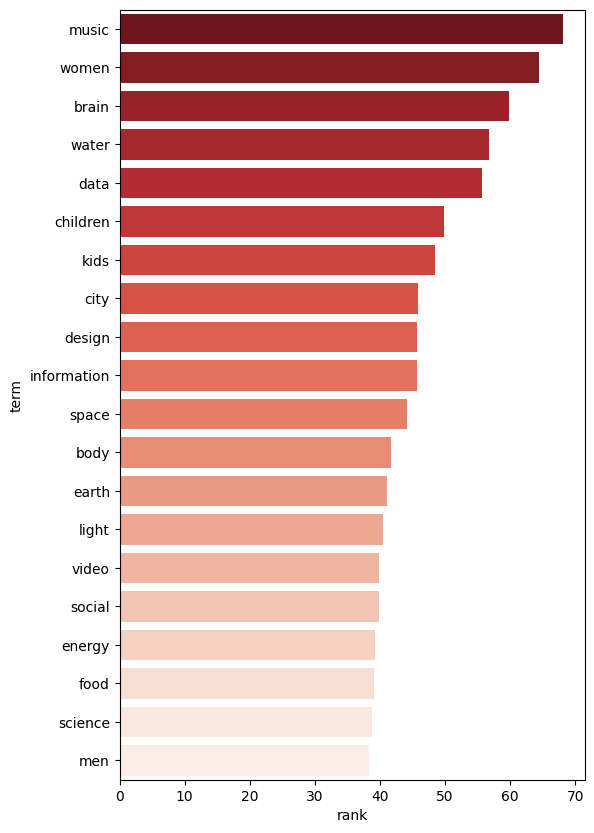

In [23]:
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
print(ranked)
fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

In [13]:
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 1.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: C:\Users\Asus\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


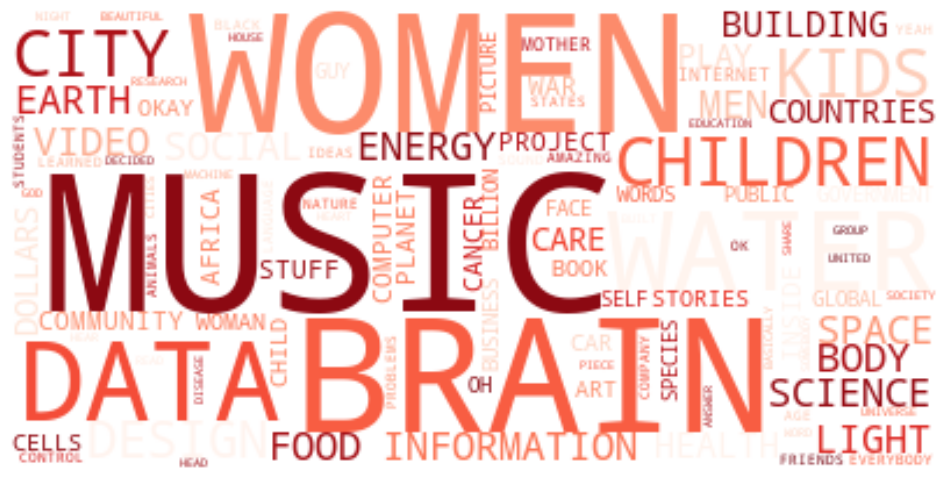

In [24]:
dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='Reds').generate_from_frequencies(dic)
fig = plt.figure(1,figsize=(12,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [25]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['song', 'music', 'awesome', 'dance', 'capture'],
 1: ['song', 'music', 'awesome', 'dance', 'capture'],
 2: ['ca', 'welcome', 'chose', 'cause', 'song'],
 3: ['cancer', 'cells', 'drug', 'patients', 'drugs'],
 4: ['song', 'music', 'awesome', 'dance', 'capture'],
 5: ['song', 'music', 'awesome', 'dance', 'capture'],
 6: ['women', 'brain', 'water', 'music', 'data'],
 7: ['music', 'ends', 'starts', 'brother', 'sorry'],
 8: ['song', 'music', 'awesome', 'dance', 'capture'],
 9: ['song', 'music', 'awesome', 'dance', 'capture']}

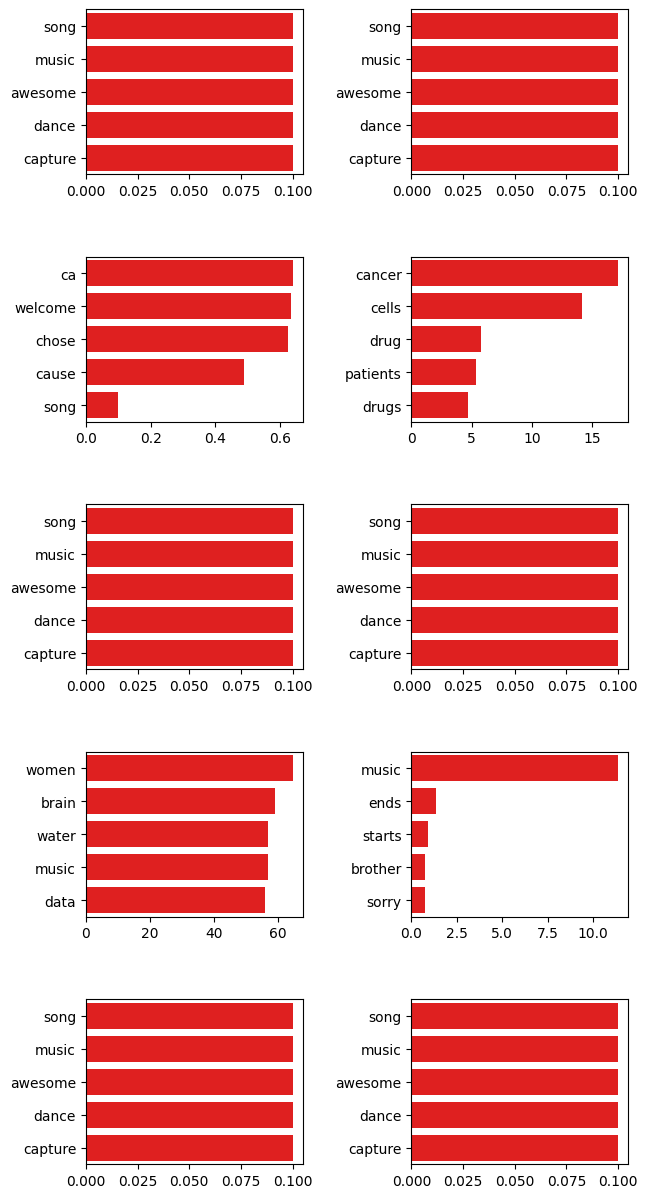

In [26]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [8]:
from sklearn.decomposition import NMF

n_topics = 10
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{0: ['god', 'book', 'stories', 'oh', 'art'],
 1: ['women', 'men', 'girls', 'woman', 'sex'],
 2: ['music', 'play', 'sound', 'song', 'ends'],
 3: ['brain', 'brains', 'cells', 'body', 'activity'],
 4: ['water', 'earth', 'planet', 'ocean', 'species'],
 5: ['countries', 'africa', 'government', 'global', 'dollars'],
 6: ['cancer', 'cells', 'patients', 'disease', 'cell'],
 7: ['data', 'information', 'computer', 'machine', 'internet'],
 8: ['city', 'design', 'cities', 'building', 'buildings'],
 9: ['kids', 'children', 'education', 'students', 'teachers']}

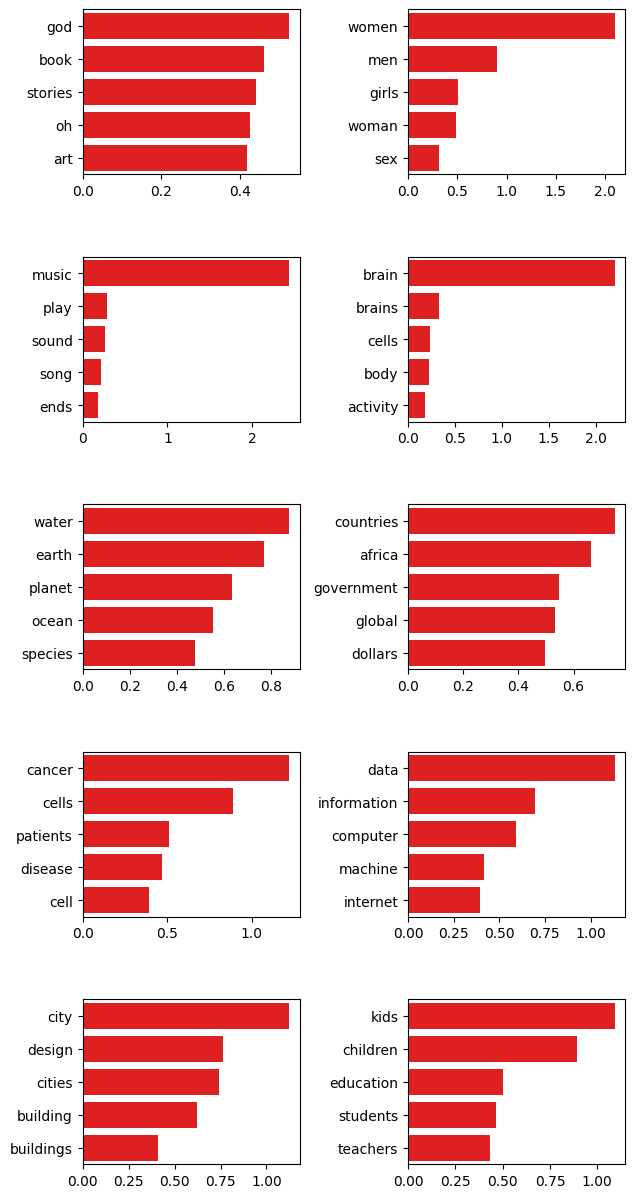

In [14]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [10]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

document_id = 4
t = pipe.transform([transcripts_df['transcript'].iloc[document_id]]) 
print('Topic distribution for document #{}: \n'.format(document_id),t)
print('Relevant topics for document #{}: \n'.format(document_id),np.where(t>0.01)[1])
print('\nTranscript:\n',transcripts_df['transcript'].iloc[document_id][:500],'...')

talk = ted_main_df[ted_main_df['url']==transcripts_df['url'].iloc[document_id]]
print('\nTrue tags from ted_main.csv: \n',talk['tags'])

Topic distribution for document #4: 
 [[0.         0.         0.         0.         0.         0.12173757
  0.         0.06553909 0.         0.04614167]]
Relevant topics for document #4: 
 [5 7 9]

Transcript:
 About 10 years ago, I took on the task to teach global development to Swedish undergraduate students. That was after having spent about 20 years together with African institutions studying hunger in Africa, so I was sort of expected to know a little about the world. And I started in our medical university, Karolinska Institute, an undergraduate course called Global Health. But when you get that opportunity, you get a little nervous. I thought, these students coming to us actually have the highes ...

True tags from ted_main.csv: 
 4    ['Africa', 'Asia', 'Google', 'demo', 'economic...
Name: tags, dtype: object


In [11]:
t = pipe.transform(transcripts_df['transcript']) 
t = pd.DataFrame(t, columns=[str(t_words[i]) for i in range(0,10)])
t.head()

,"['god', 'book', 'stories', 'oh', 'art']","['women', 'men', 'girls', 'woman', 'sex']","['music', 'play', 'sound', 'song', 'ends']","['brain', 'brains', 'cells', 'body', 'activity']","['water', 'earth', 'planet', 'ocean', 'species']","['countries', 'africa', 'government', 'global', 'dollars']","['cancer', 'cells', 'patients', 'disease', 'cell']","['data', 'information', 'computer', 'machine', 'internet']","['city', 'design', 'cities', 'building', 'buildings']","['kids', 'children', 'education', 'students', 'teachers']"
0,0.045294,0.025600,0.031291,0.021999,0.016566,0.000000,0.000000,0.000000,0.000000,0.169279
1,0.028425,0.000000,0.000205,0.000000,0.035379,0.070929,0.000000,0.003852,0.040108,0.000000
2,0.061137,0.000000,0.036781,0.000000,0.000000,0.011582,0.000000,0.085554,0.008221,0.000000
3,0.007895,0.010683,0.000000,0.000000,0.021368,0.061034,0.001448,0.000000,0.156569,0.033682
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.121738,0.000000,0.065539,0.000000,0.046141


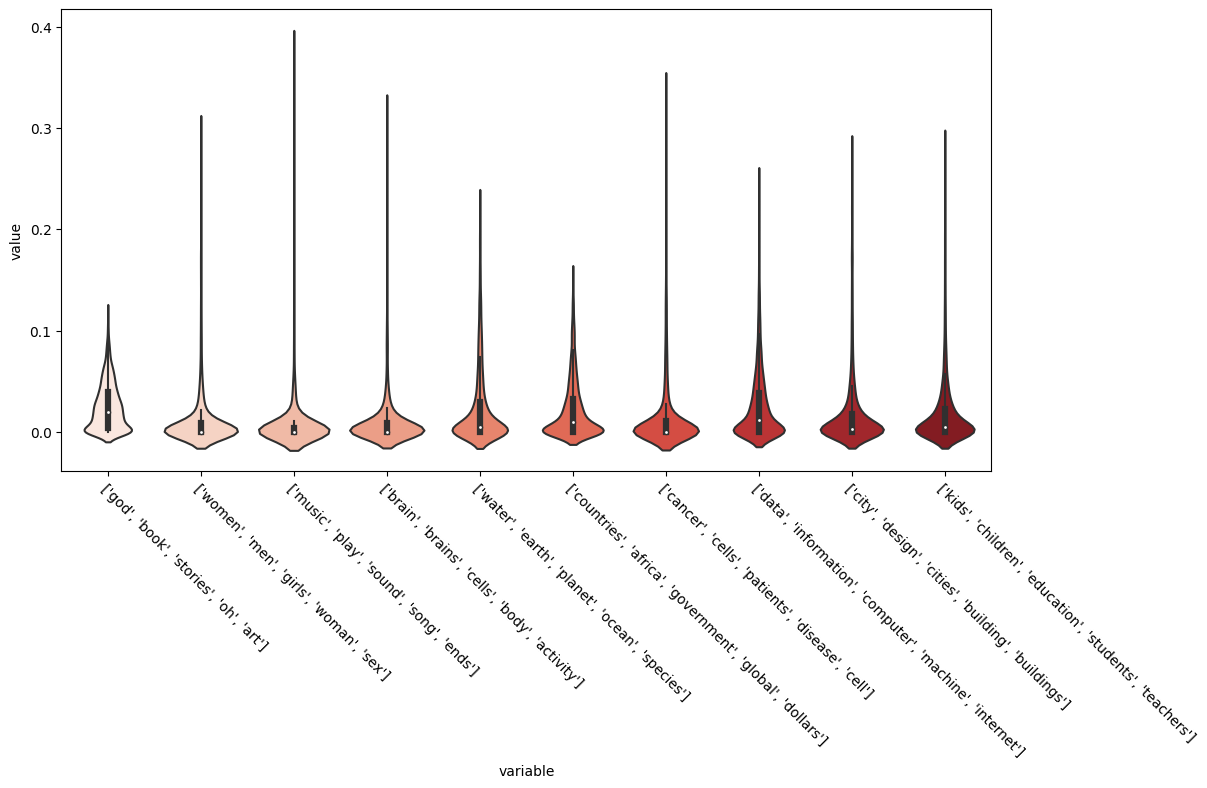

In [14]:
new_t = t.melt()


fig, ax = plt.subplots(figsize=(12,6), ncols=1, nrows=1)
sns.violinplot(x="variable", y="value", data=new_t, palette='Reds', ax=ax)

plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

plt.show()